# <u>Detección de Fake News con Modelos de Machine Learning</u>

In [ ]:
# Importación de Librerías

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [ ]:
# Descargar dependencias de NLTK

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Cargar dataset
df = pd.read_csv('/content/fake_or_real_news.csv')

In [ ]:
# Contar la cantidad de noticias verdaderas y falsas

label_counts = df['label'].value_counts()
print(f"Distribución de clases:\n{label_counts}")

Distribución de clases:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


<ipython-input-5-5eb76b83b670>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


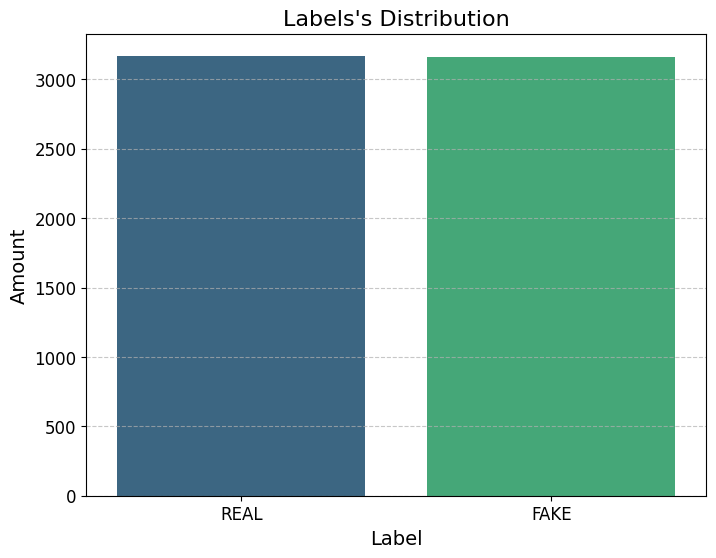

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar las ocurrencias de cada etiqueta
label_counts = df["label"].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Labels's Distribution", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Amount", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('labels.svg', format='svg')
plt.show()

## <u>Preprocesamiento de datos</u>

In [ ]:
# Preprocesamiento del texto
# stop_words es un conjunto de palabras comunes en inglés (como "the", "is", "in")
# que no aportan mucho significado y, por lo tanto, se eliminan durante el preprocesamiento.

stop_words = set(stopwords.words('english'))

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

* La función preprocess_text procesa el texto:
    * Convierte todo a minúsculas con text.lower() para evitar inconsistencias debidas a mayúsculas/minúsculas.
    * Tokeniza el texto con word_tokenize, dividiendo el texto en palabras individuales.
    * Filtra las palabras:
      + Conserva solo las palabras alfabéticas (word.isalpha()).
      + Excluye las palabras vacías definidas en stop_words.
    * Une las palabras filtradas en una cadena de texto limpia.

In [ ]:
# Aplica esta función a la columna text del DataFrame df y almacena el texto
# preprocesado en una nueva columna llamada cleaned_text.

df['cleaned_text'] = df['text'].apply(preprocess_text)

In [ ]:
# Convertir etiquetas a binario
df['label'] = df['label'].apply(lambda x: 1 if x == 'REAL' else 0)

In [ ]:
# Representación TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text']).toarray()
y = df['label'].values

Utiliza TF-IDF (Term Frequency-Inverse Document Frequency) para convertir el texto preprocesado en vectores numéricos que los modelos de Machine Learning pueden entender:

* `max_features=5000` limita el vocabulario a las 5000 palabras más importantes, lo que ayuda a reducir la dimensionalidad y mantener características relevantes.
* `fit_transform` ajusta el modelo TF-IDF a los datos y transforma el texto en vectores. El resultado se convierte a un array denso con toarray().


`X` contiene las características extraídas del texto y y contiene las etiquetas binarias.


In [ ]:
# Balanceo de clases
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

Utiliza SMOTE (Synthetic Minority Oversampling Technique) para manejar el desbalanceo en las clases:
* Si las clases en `y` (como `0` y `1`) están desbalanceadas, SMOTE genera nuevas muestras sintéticas para la clase minoritaria, equilibrando así las clases en los datos.
* Esto evita que los modelos de ML favorezcan la clase mayoritaria.

In [ ]:
# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Divide los datos en conjuntos de entrenamiento (70%) y prueba (30%):
* `stratify=y` asegura que la proporción de clases (balanceo) se mantenga igual en ambos conjuntos.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Configurar validación cruzada

# Divide los datos en 5 partes (n_splits=5), asegurando que la proporción de clases
# en cada división sea la misma que en el conjunto original.

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Función para ejecutar modelos y GridSearch

# - Utiliza GridSearchCV para encontrar la mejor combinación de hiperparámetros especificados en param_grid.
# - scoring='accuracy' evalúa el modelo en función de la precisión.
# - cv=cv usa la validación cruzada previamente configurada.
# - n_jobs=-1 permite usar múltiples núcleos del procesador para acelerar el proceso.

def train_and_evaluate_model(model, param_grid, model_name):
    # Configurar GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='accuracy', cv=cv, verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Predicciones en el conjunto de prueba
    y_pred = best_model.predict(X_test)

    # Cálculo de métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    print(f"\n{model_name} - Resultados:")
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precisión (Precision): {precision*100:.2f}%")
    print(f"Sensibilidad (Recall): {recall*100:.2f}%")
    print(f"F1-Score: {f1*100:.2f}%")
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")

    # Informe detallado de métricas
    print("\nInforme de clasificación:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

    # Retornar el mejor modelo encontrado
    return best_model

## <u>Regresión Logística</u>

Fitting 5 folds for each of 3 candidates, totalling 15 fits

Regresión Logística - Resultados:
Accuracy: 92.96%
Precisión (Precision): 93.14%
Sensibilidad (Recall): 92.74%
F1-Score: 92.94%
Mejores hiperparámetros: {'C': 10, 'penalty': 'l2'}

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       952
           1       0.93      0.93      0.93       951

    accuracy                           0.93      1903
   macro avg       0.93      0.93      0.93      1903
weighted avg       0.93      0.93      0.93      1903



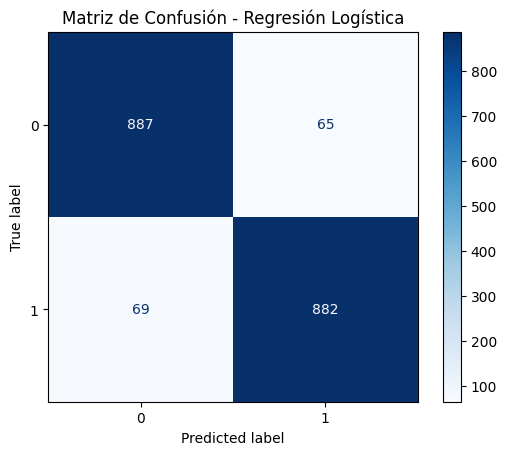

In [ ]:
# Regresión Logística

logreg_param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
}
best_logreg_model = train_and_evaluate_model(LogisticRegression(solver='liblinear'), logreg_param_grid,"Regresión Logística")

## <u>AdaBoost</u>

Fitting 5 folds for each of 4 candidates, totalling 20 fits

AdaBoost - Resultados:
Accuracy: 85.97%
Precisión (Precision): 88.51%
Sensibilidad (Recall): 82.65%
F1-Score: 85.48%
Mejores hiperparámetros: {'learning_rate': 1, 'n_estimators': 100}

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       952
           1       0.89      0.83      0.85       951

    accuracy                           0.86      1903
   macro avg       0.86      0.86      0.86      1903
weighted avg       0.86      0.86      0.86      1903



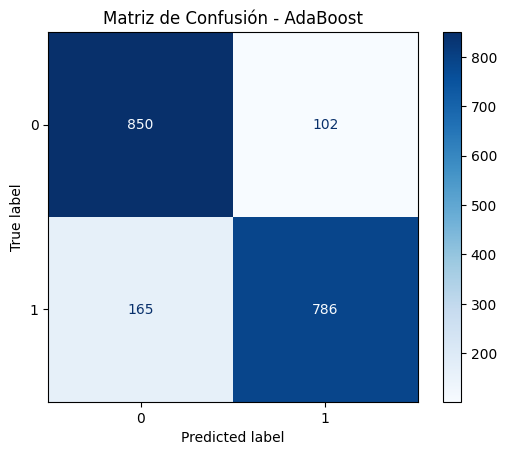

In [ ]:
# AdaBoost
adaboost_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 1],
}
best_adaboost_model = train_and_evaluate_model(AdaBoostClassifier(), adaboost_param_grid, "AdaBoost")


## <u>SVM</u>

Fitting 5 folds for each of 12 candidates, totalling 60 fits

SVM - Resultados:
Accuracy: 93.75%
Precisión (Precision): 94.92%
Sensibilidad (Recall): 92.43%
F1-Score: 93.66%
Mejores hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

Informe de clasificación:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       952
           1       0.95      0.92      0.94       951

    accuracy                           0.94      1903
   macro avg       0.94      0.94      0.94      1903
weighted avg       0.94      0.94      0.94      1903



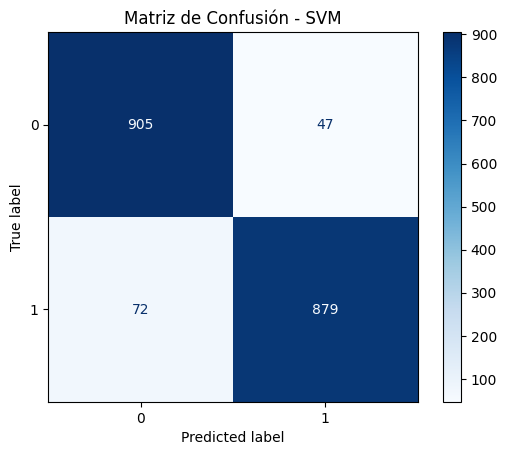

In [ ]:
# SVM
svm_param_grid = {
    'C': [1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}
best_svm_model = train_and_evaluate_model(SVC(probability=True), svm_param_grid, "SVM")

## <u>Gráfico del Área bajo la curva de los tres modelos utilizados</u>

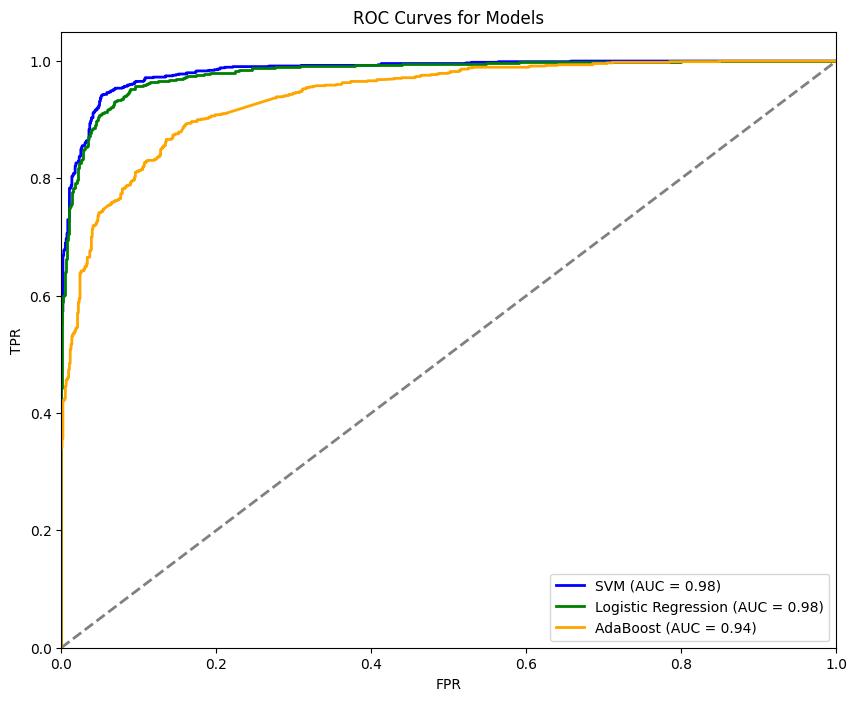

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Función para calcular la curva ROC y el AUC
def plot_roc_curve(model, X_test, y_test, model_name, color):
    y_prob = model.predict_proba(X_test)[:, 1]  # Obtener las probabilidades
    fpr, tpr, _ = roc_curve(y_test, y_prob)  # Calcular FPR y TPR
    roc_auc = auc(fpr, tpr)  # Calcular AUC

    # Graficar la curva ROC
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    return roc_auc

# Configurar el gráfico
plt.figure(figsize=(10, 8))
plt.title('ROC Curves for Models')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Línea diagonal (azar)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')

# Calcular y graficar las curvas para cada modelo
auc_svm = plot_roc_curve(best_svm_model, X_test, y_test, 'SVM', 'blue')
auc_logreg = plot_roc_curve(best_logreg_model, X_test, y_test, 'Logistic Regression', 'green')
auc_adaboost = plot_roc_curve(best_adaboost_model, X_test, y_test, 'AdaBoost', 'orange')
#auc_xgboost = plot_roc_curve(best_xgboost_model, X_test, y_test, 'XGBoost', 'red')

# Agregar leyenda
plt.legend(loc='lower right')

# Guardar el gráfico como archivo SVG
plt.savefig('ROC.svg', format='svg')


# Mostrar el gráfico
plt.show()